# PyTorch With Baby Steps: From y = x To Training A Convolutional Neural Network

[Take me to the outline!](#outline)

## Motivation:

As I was going through the Deep Learning Blitz tutorial from pytorch.org (found here: http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), I had a lot of questions. I googled my way through all of them, but I had wished there was a more extensive example set (i.e. starting from a really basic model all the way to a CNN). That way I could see very clearly, through examples, what each component did in isolation.

Since I did that for myself, I figured I might as well put it online for everyone else who's learning PyTorch. This is not designed to be an end-all-be-all tutorial (in fact, I use a lot of pytorch tutorial code myself), so for each section, I'll link to various resources that helped me understand the concepts. Hopefully, in conjunction with the examples, it'll be helpful.

Please feel free to email me if you have any questions or suggestions: jlelonmitchell@gmail.com

Here are other things I might do more tutorials on if reception is good and people request them:

network architecture, batch normalization, vanishing gradients, dropout, initialization techniques, non-convex optimization, biases, choices of loss functions, data augmentation, regularization methods, computational considerations, modifications of backpropagation

# Outline: <a id='outline'></a>

1) [Bare Minimum Model](#one): create an absolute bare minimum model with Tensors

2) [Basic Linear Regression Model](#two): create a basic linear regression model (i.e. no training or anything yet; just initializing it and doing the calculation)

3) [Calculate Loss](#three): calculate our (linear regression) model's loss using a loss function

4) [Calculating Our Gradient](#four): calculate our gradient based on the previous loss function

5) [Recalculating/Updating Our Weights](#five): calculate the change in our weights based on the gradient and updating them

6) [Updating Our Weights More Than Once](#six): set up a for loop to do steps 3-5 an arbitrary number of times (i.e. epochs)

7) [Making Our Epochs Only Use A Subset Of The Data](#seven): make the for loop only use a portion of the data (i.e. a batch)

8) [Changing Our Model from Linear Regression to Neural Network](#eight): make it fit the data better

9) [Abstracting Our Neural Network Into Its Pytorch Class](#nine): make it more maintainable and less messy

10) [Changing Our Input From Arbitrary Vectors To Images](#ten): make it do something more interesting

11) [Adding A Convolutional Layer](#eleven): make our model do convolutions before it does the other stuff

12) [Adding A Pooling Layer](#twelve): make our model faster by only taking the biggest "most important" values into consideration

13) [Making More Optimizations](#thirteen): change our activation functions to ReLU, add more layers, and other housekeeping

14) [Bask in the glory of our newly minted Convolutional Neural Network](#fourteen)

In [1]:
import torch # Tensor Package (for use on GPU)
from torch.autograd import Variable # for computational graphs
import torch.nn as nn ## Neural Network package
import torch.nn.functional as F # Non-linearities package
import torch.optim as optim # Optimization package
from torch.utils.data import Dataset, TensorDataset, DataLoader # for dealing with data
import torchvision # for dealing with vision data
import torchvision.transforms as transforms # for modifying vision data to run it through models

import matplotlib.pyplot as plt # for plotting
import numpy as np

<a id='one'></a>

# 1)  Bare Minimum Model: 

#### [Home](#outline)  |   [Back](#outline)  |   [Next](#two)

Links:
- http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html - Pytorch's Tensor Tutorial
- https://www.google.com/search?q=PyTorch+Tensor+Examples - More Examples

### Quick Tensor Demonstration:

In [2]:
# here's a one dimensional array the pytorch way (i.e. allowing GPU computations):
x1 = torch.Tensor([1, 2, 3, 4])

# here's a two dimensional array (i.e. of size 2 x 4):
x2 = torch.Tensor([[5, 6, 7, 8], [9, 10, 11, 12]])

# here's a three dimensional array (i.e. of size 2 x 2 x 4):
x3 = torch.Tensor([[[1, 2, 3, 4], [5, 6, 7, 8]], [[9, 10, 11, 12], [13, 14, 15, 16]]])

In [3]:
# x1

print("----------------------------------------")
print(x1[0])
print("----------------------------------------")
# prints 1.0

----------------------------------------
1.0
----------------------------------------


In [4]:
# x2

print("----------------------------------------")
print(x2[0, 0]) 
# prints 5.0; the first entry of the first vector

print("----------------------------------------")
print(x2[0, :]) 
# prints 5, 6, 7, 8; all the entries of the first vector

print("----------------------------------------")
print(x2[:, 2])
print("----------------------------------------")
# prints 7, 11; all the third entries of each vector vector

----------------------------------------
5.0
----------------------------------------

 5
 6
 7
 8
[torch.FloatTensor of size 4]

----------------------------------------

  7
 11
[torch.FloatTensor of size 2]

----------------------------------------


In [5]:
# x3

print("----------------------------------------")
print(x3[0, 0, 0]) 
# prints 1.0; the first entry of the first vector of the first set of vectors

print("----------------------------------------")
print(x3[:, 0, 0]) 
# prints 1, 9; the first entry of each first vector in each set of vectors

print("----------------------------------------")
print(x3[0, :, 0]) 
# prints 1, 5; pick the first set of vectors, and from each vector, choose the first entry

print("----------------------------------------")
print(x3[0, 0, :]) 
print("----------------------------------------")
# prints 1, 2, 3, 4; everything in the first vector of the first set

----------------------------------------
1.0
----------------------------------------

 1
 9
[torch.FloatTensor of size 2]

----------------------------------------

 1
 5
[torch.FloatTensor of size 2]

----------------------------------------

 1
 2
 3
 4
[torch.FloatTensor of size 4]

----------------------------------------


### Bare Minimum Model (y = x)

In [6]:
x1_node = Variable(x1, requires_grad=True)
# we put our tensor in a Variable so we can use it for training and other stuff later

print("----------------------------------------")
print(x1_node)
print("----------------------------------------")
# prints Variable containing 1, 2, 3, 4

----------------------------------------
Variable containing:
 1
 2
 3
 4
[torch.FloatTensor of size 4]

----------------------------------------


In [7]:
y_node = x1_node
# we did some "stuff" to x1_node (except we didn't do anything) and then assigned the result to a new y variable

print("----------------------------------------")
print(y_node)
print("----------------------------------------")
# prints Variable containing 1, 2, 3, 4

----------------------------------------
Variable containing:
 1
 2
 3
 4
[torch.FloatTensor of size 4]

----------------------------------------


<a id='two'></a>

# 2)  Basic Linear Regression Model 

Links:
- http://pytorch.org/docs/0.3.1/nn.html#linear-layers - pytorch linear layer documentation
- https://www.khanacademy.org/math/ap-statistics/bivariate-data-ap/least-squares-regression/v/example-estimating-from-regression-line - Khan Academy
- https://www.google.com/search?q=Linear+Regression+Examples - More Examples

#### [Home](#outline)  |   [Back](#one)  |   [Next](#three)

In [8]:
x1 = torch.Tensor([1, 2, 3, 4])
x1_var = Variable(x1, requires_grad=True)

linear_layer1 = nn.Linear(4, 1)
# create a linear layer (i.e. a linear equation: w1x1 + w2x2 + w3x3 + w4x4 + b, with 4 inputs and 1 output)
# w and b stand for weight and bias, respectively

predicted_y = linear_layer1(x1_var)
# run the x1 variable through the linear equation and put the output in predicted_y

print("----------------------------------------")
print(predicted_y)
print("----------------------------------------")
# prints the predicted y value (the weights and bias are initialized randomly; my output was 1.3712)

----------------------------------------
Variable containing:
-0.6885
[torch.FloatTensor of size 1]

----------------------------------------


<a id='three'></a>

# 3)  Calculating The Loss Function 

Links:
- https://stackoverflow.com/questions/42877989/what-is-a-loss-function-in-simple-words - good SO post
- http://pytorch.org/docs/0.3.1/nn.html#id38 - pytorch loss functions documentation
- https://en.wikipedia.org/wiki/Loss_function - wikipedia
- https://www.google.com/search?q=Loss+Function+Examples - More Examples


#### [Home](#outline)  |   [Back](#two)  |   [Next](#four)

In [9]:
x1 = torch.Tensor([1, 2, 3, 4])
x1_var = Variable(x1, requires_grad=True)

linear_layer1 = nn.Linear(4, 1)

target_y = Variable(torch.Tensor([0]), requires_grad=False)
# ideally, we want our model to predict 0 when we input our x1_var variable below.
# here we're just sticking a Tensor with just 0 in it into a variable, and labeling it our target y value
# I put requires_grad=False because we're not computing any gradient with respect to our target (more on that later)

predicted_y = linear_layer1(x1_var)
print("----------------------------------------")
print(predicted_y)
print("----------------------------------------")
# prints 3.0995 for me; will probably be different for you.

loss_function = nn.MSELoss()
# this creates a function that takes a ground-truth Tensor and your model's output Tensor as inputs and calculates the "loss"
# in this case, it calculates the Mean Squared Error (a measurement for how far away your output is from where it should be)

loss = loss_function(predicted_y, target_y)
# here we actually use the function to compare our predicted_y vs our target_y

print(loss)
print("----------------------------------------")
# prints 9.6067 for me; will probably be different for you. It's just (target_y - predicted_y)^2 in this case.

----------------------------------------
Variable containing:
-0.2311
[torch.FloatTensor of size 1]

----------------------------------------
Variable containing:
1.00000e-02 *
  5.3404
[torch.FloatTensor of size 1]

----------------------------------------


<a id='four'></a>

# 4)  Calculating Our Gradient (based on the loss function) 

Links:
- http://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html - pytorch's automatic gradient package
- https://discuss.pytorch.org/t/how-the-backward-works-for-torch-variable/907/3 - good discussion on pytorch forums
- https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/gradient-and-directional-derivatives/v/gradient - Khan Academy
- https://www.google.com/search?q=Machine+Learning+Gradient+Examples - More Examples

#### [Home](#outline)  |   [Back](#three)  |   [Next](#five)

In [10]:
x1 = torch.Tensor([1, 2, 3, 4])
x1_var = Variable(x1, requires_grad=True)

linear_layer1 = nn.Linear(4, 1)

target_y = Variable(torch.Tensor([0]), requires_grad=False)

predicted_y = linear_layer1(x1_var)

loss_function = nn.MSELoss()

loss = loss_function(predicted_y, target_y)

# at this point, we want the gradient of our loss function with respect to our original input, x
# the Variable object we put our Tensor in is supposed to store its respective gradients, so let's look:

print("----------------------------------------")
print(x1_var.grad)
print("----------------------------------------")

# this prints None, because we haven't computed any gradients yet.
# we have to call the backward() function from our loss results in order to compute gradients with respect to x

loss.backward()
print(x1_var.grad)
print("----------------------------------------")
# This is the gradient Tensor that holds the partial derivatives of our loss function with respect to each entry in x1

----------------------------------------
None
----------------------------------------
Variable containing:
-0.7361
-1.0644
 1.4180
 1.2542
[torch.FloatTensor of size 4]

----------------------------------------


<a id='five'></a>

# 5)  Recalculating/Updating Our Weights (based on the gradient) 

Links:
- http://pytorch.org/docs/master/optim.html - optimizer package documentation

#### [Home](#outline)  |   [Back](#four)  |   [Next](#six)

In [11]:
x1 = torch.Tensor([1, 2, 3, 4])
x1_var = Variable(x1, requires_grad=True)

linear_layer1 = nn.Linear(4, 1)

target_y = Variable(torch.Tensor([0]), requires_grad=False)

predicted_y = linear_layer1(x1_var)

loss_function = nn.MSELoss()

loss = loss_function(predicted_y, target_y)

optimizer = optim.SGD(linear_layer1.parameters(), lr=1e-1)
# here we've created an optimizer object that's responsible for changing the weights
# we told it which weights to change (those of our linear_layer1 model) and how much to change them (learning rate / lr)
# but we haven't quite told it to change anything yet. First we have to calculate the gradient.

loss.backward()

# now that we have the gradient, let's look at our weights before we change them:

print("----------------------------------------")
print("Weights (before update):")
print(linear_layer1.weight)
print(linear_layer1.bias)
# let's also look at what our model predicts the output to be:

print("----------------------------------------")
print("Output (before update):")
print(linear_layer1(x1_var))

optimizer.step()
# we told the optimizer to subtract the learning rate * the gradient from our model weights

print("----------------------------------------")
print("Weights (after update):")
print(linear_layer1.weight)
print(linear_layer1.bias)

# looks like our weights and biases changed. How do we know they changed for the better?
# let's also look at what our model predicts the output to be now:

print("----------------------------------------")
print("Output (after update):")
print(linear_layer1(x1_var))
print("----------------------------------------")

# wow, that's a huge change (at least for me, and probably for you). It looks like our learning rate might be too high.
# perhaps we want to make our model learn slower, compensating with more than one weight update?
# next section!

----------------------------------------
Weights (before update):
Parameter containing:
 0.1946  0.4250 -0.4268  0.2506
[torch.FloatTensor of size 1x4]

Parameter containing:
-0.1696
[torch.FloatTensor of size 1]

----------------------------------------
Output (before update):
Variable containing:
 0.5969
[torch.FloatTensor of size 1]

----------------------------------------
Weights (after update):
Parameter containing:
 0.0752  0.1862 -0.7849 -0.2269
[torch.FloatTensor of size 1x4]

Parameter containing:
-0.2890
[torch.FloatTensor of size 1]

----------------------------------------
Output (after update):
Variable containing:
-3.1037
[torch.FloatTensor of size 1]

----------------------------------------


<a id='six'></a>

# 6)  Updating Our Weights More Than Once (i.e. doing step 3-6 a few times aka "epochs") 

Links:
- https://wiki.python.org/moin/ForLoop - for loops in python

#### [Home](#outline)  |   [Back](#five)  |   [Next](#seven)

In [12]:
# this block of code is organized a little differently than section 5, but it's mostly the same code
# the only three differences are:
# - The "Hyperparameter" constants
# - The for loop (for helping the model do <number of epochs> training steps)
# - The linear_layer1.zero_grad() function call on line 25. 
#   (that's just to clear the gradients in memory, since we're starting the training over each iteration/epoch)

x1 = torch.Tensor([1, 2, 3, 4])
x1_var = Variable(x1, requires_grad=True)

linear_layer1 = nn.Linear(4, 1)

target_y = Variable(torch.Tensor([0]), requires_grad=False)

print("----------------------------------------")
print("Output (BEFORE UPDATE):")
print(linear_layer1(x1_var))

NUMBER_OF_EPOCHS = 3 # Number of times to update the weights
LEARNING_RATE = 1e-4 # Notice how I made the learning rate 1000 times smaller
loss_function = nn.MSELoss()
optimizer = optim.SGD(linear_layer1.parameters(), lr=LEARNING_RATE)

for epoch in range(NUMBER_OF_EPOCHS):
    linear_layer1.zero_grad()
    predicted_y = linear_layer1(x1_var)
    loss = loss_function(predicted_y, target_y)
    loss.backward()
    optimizer.step()
    
    print("----------------------------------------")
    print("Output (UPDATE " + str(epoch + 1) + "):")
    print(linear_layer1(x1_var))
    print("Should be getting closer to 0...")

print("----------------------------------------")

# here is where you might discover that training could take a *long* time
# we're barely doing anything, computationally speaking, and it's already scaling up
# in the next section, we're going to add more data (other than one sample with 4 features), 
# and then, with each epoch, we're only going to use a small portion of it (called a "batch").

----------------------------------------
Output (BEFORE UPDATE):
Variable containing:
-2.9463
[torch.FloatTensor of size 1]

----------------------------------------
Output (UPDATE 1):
Variable containing:
-2.9281
[torch.FloatTensor of size 1]

Should be getting closer to 0...
----------------------------------------
Output (UPDATE 2):
Variable containing:
-2.9099
[torch.FloatTensor of size 1]

Should be getting closer to 0...
----------------------------------------
Output (UPDATE 3):
Variable containing:
-2.8919
[torch.FloatTensor of size 1]

Should be getting closer to 0...
----------------------------------------


<a id='seven'></a>

# 7)  Making Our Epochs Only Use A Subset Of The Data (i.e. a "batch") 

Links:
- https://discuss.pytorch.org/t/zero-grad-optimizer-or-net/1887 - good discussion on pytorch forums
- https://stats.stackexchange.com/questions/49528/batch-gradient-descent-versus-stochastic-gradient-descent - good SE post
- http://pytorch.org/docs/master/data.html - data utilities pytorch documentation
- http://pytorch.org/tutorials/beginner/data_loading_tutorial.html - pytorch's data loading and processing tutorial

#### [Home](#outline)  |   [Back](#six)  |   [Next](#eight)

In [13]:
x = torch.Tensor([[0, 0, 1, 1],
                 [0, 1, 1, 0],
                 [1, 0, 1, 0],
                 [1, 1, 1, 1]])
target_y = torch.Tensor([0, 1, 1, 0])
# now, instead of having 1 data sample, we have 4 (oh yea, now we're in the big leagues)
# but, pytorch has a DataLoader class to help us scale up, so let's use that.

inputs = x # let's use the same naming convention as the pytorch documentation here
labels = target_y # and here

train = TensorDataset(inputs, labels) # here we're just putting our data samples into a tiny Tensor dataset

trainloader = DataLoader(train, batch_size=2, shuffle=False) # and then putting the dataset above into a data loader
# the batchsize=2 option just means that, later, when we iterate over it, we want to run our model on 2 samples at a time

linear_layer1 = nn.Linear(4, 1)

NUMBER_OF_EPOCHS = 3
LEARNING_RATE = 1e-4
loss_function = nn.MSELoss()
optimizer = optim.SGD(linear_layer1.parameters(), lr=LEARNING_RATE)

for epoch in range(NUMBER_OF_EPOCHS):
    train_loader_iter = iter(trainloader) # here's the iterator we use to iterate over our training set
    for batch_idx, (inputs, labels) in enumerate(train_loader_iter): # here we split apart our data so we can run it
        linear_layer1.zero_grad()
        inputs, labels = Variable(inputs.float()), Variable(labels.float())
        predicted_y = linear_layer1(inputs)
        loss = loss_function(predicted_y, labels)
        loss.backward()
        optimizer.step()
        print("----------------------------------------")
        print("Output (UPDATE: Epoch #" + str(epoch + 1) + ", Batch #" + str(batch_idx + 1) + "):")
        print(linear_layer1(Variable(x)))
        print("Should be getting closer to [0, 1, 1, 0]...") # but some of them aren't! we need a model that fits better...
                                                             # next up, we'll convert this model from regression to a NN

print("----------------------------------------")


----------------------------------------
Output (UPDATE: Epoch #1, Batch #1):
Variable containing:
-0.3699
 0.1028
 0.0181
 0.2637
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------
Output (UPDATE: Epoch #1, Batch #2):
Variable containing:
-0.3698
 0.1030
 0.0184
 0.2639
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------
Output (UPDATE: Epoch #2, Batch #1):
Variable containing:
-0.3695
 0.1033
 0.0186
 0.2643
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------
Output (UPDATE: Epoch #2, Batch #2):
Variable containing:
-0.3694
 0.1034
 0.0188
 0.2644
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------
Output (UPDATE: Epoch #3, Batch #1):
Variable containing:
-0.3691
 0.1038
 0.0191
 0.2648
[torch.FloatTensor of size 4x1]

Shou

<a id='eight'></a>

# 8)  Changing Our Model from Linear Regression to Neural Network (to make it fit the data better) 

Links:
- https://www.youtube.com/watch?v=aircAruvnKk - Good video on what a neural network is (3blue1brown)
- http://neuralnetworksanddeeplearning.com - Good online book on neural networks
- https://www.deeplearningbook.org - *The* deep learning book

#### [Home](#outline)  |   [Back](#seven)  |   [Next](#nine)

In [14]:
x = torch.Tensor([[0, 0, 1, 1],
                 [0, 1, 1, 0],
                 [1, 0, 1, 0],
                 [1, 1, 1, 1]])
target_y = torch.Tensor([0, 1, 1, 0])

inputs = x
labels = target_y

train = TensorDataset(inputs, labels)
trainloader = DataLoader(train, batch_size=4, shuffle=False)

linear_layer1 = nn.Linear(4, 2)
sigmoid = nn.Sigmoid() # this is the nonlinearity that we pass the output from layers 1 and 2 into
linear_layer2 = nn.Linear(2, 1) # this is our second layer (i.e. we're going to pass the outputs from sigmoid into here)

NUMBER_OF_EPOCHS = 3
LEARNING_RATE = 1e-1 # increased learning rate to make learning more obvious
loss_function = nn.MSELoss()
optimizer = optim.SGD(linear_layer1.parameters(), lr=LEARNING_RATE)

for epoch in range(NUMBER_OF_EPOCHS):
    train_loader_iter = iter(trainloader)
    for batch_idx, (inputs, labels) in enumerate(train_loader_iter):
        linear_layer1.zero_grad()
        inputs, labels = Variable(inputs.float()), Variable(labels.float())
        
        linear_layer1_output = linear_layer1(inputs)
        sigmoid_output = sigmoid(linear_layer1_output)
        linear_layer2_output = linear_layer2(sigmoid_output)
        sigmoid_output_2 = sigmoid(linear_layer2_output) # see how the output from one layer just goes into the second?
        
        loss = loss_function(sigmoid_output_2, labels)
        loss.backward()
        optimizer.step()
        print("----------------------------------------")
        print("Output (UPDATE: Epoch #" + str(epoch + 1) + ", Batch #" + str(batch_idx + 1) + "):")
        print(sigmoid(linear_layer2(sigmoid(linear_layer1(Variable(x)))))) # the nested functions are getting out of hand..
        print("Should be getting closer to [0, 1, 1, 0]...") # they are if you increase the epochs amount... but it's slow!

print("----------------------------------------")

# Awesome, so we have a neural network (nn). But the nested functions and all the layers are starting to get bloated.
# Time to refactor. Luckily, PyTorch provides a class specifically for this: the Net class. We'll port our code there next.


----------------------------------------
Output (UPDATE: Epoch #1, Batch #1):
Variable containing:
 0.2646
 0.2660
 0.2698
 0.2578
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------
Output (UPDATE: Epoch #2, Batch #1):
Variable containing:
 0.2646
 0.2661
 0.2699
 0.2579
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------
Output (UPDATE: Epoch #3, Batch #1):
Variable containing:
 0.2647
 0.2662
 0.2700
 0.2580
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------


<a id='nine'></a>

# 9) Abstracting our Neural Network into its PyTorch class (i.e. making it more maintainable and less messy)

Links:
- http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html - pytorch neural network tutorial

#### [Home](#outline)  |   [Back](#eight)  |   [Next](#ten)

In [15]:
x = torch.Tensor([[0, 0, 1, 1],
                 [0, 1, 1, 0],
                 [1, 0, 1, 0],
                 [1, 1, 1, 1]])
target_y = torch.Tensor([0, 1, 1, 0])

inputs = x
labels = target_y

train = TensorDataset(inputs, labels)
trainloader = DataLoader(train, batch_size=4, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 2) # here's where we define the same layers we had earlier
        self.fc2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x) # the forward function just sends everything through its respective layers
        x = sigmoid(x) # including through the sigmoids after each Linear layer
        x = self.fc2(x)
        x = sigmoid(x)
        return x

net = Net() # we made a blueprint above for our neural network, now we initialize one.

NUMBER_OF_EPOCHS = 3
LEARNING_RATE = 1e-1
loss_function = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE) # slight difference: we optimize w.r.t. the net parameters now

for epoch in range(NUMBER_OF_EPOCHS):
    train_loader_iter = iter(trainloader)
    for batch_idx, (inputs, labels) in enumerate(train_loader_iter):
        net.zero_grad() # same here: we have to zero out the gradient for the neural network's inputs
        inputs, labels = Variable(inputs.float()), Variable(labels.float())
        output = net(inputs) # but now, all we have to do is pass our inputs to the neural net 
        
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        print("----------------------------------------")
        print("Output (UPDATE: Epoch #" + str(epoch + 1) + ", Batch #" + str(batch_idx + 1) + "):")
        print(net(Variable(x))) # much better!
        print("Should be getting closer to [0, 1, 1, 0]...")

print("----------------------------------------")

# Awesome, so we have a neural network (nn) in the actual PyTorch Net class.
# As it stands right now, there's tons of optimization that can be done here.
# But, at the risk of falling for premature optimization, let's get to the end and build our full-fledged CNN first.

----------------------------------------
Output (UPDATE: Epoch #1, Batch #1):
Variable containing:
 0.5994
 0.6015
 0.5958
 0.5919
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------
Output (UPDATE: Epoch #2, Batch #1):
Variable containing:
 0.5982
 0.6003
 0.5945
 0.5907
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------
Output (UPDATE: Epoch #3, Batch #1):
Variable containing:
 0.5969
 0.5991
 0.5933
 0.5895
[torch.FloatTensor of size 4x1]

Should be getting closer to [0, 1, 1, 0]...
----------------------------------------


<a id='ten'></a>

# 10)  Changing Our Input From Arbitrary Vectors To Images 

Links:
- http://pytorch.org/docs/master/data.html - data utilities pytorch documentation
- http://pytorch.org/tutorials/beginner/data_loading_tutorial.html - pytorch's data loading and processing tutorial
- http://pytorch.org/docs/master/torchvision/transforms.html - transforms documentation
- http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html - pytorch's data classifier tutorial

#### [Home](#outline)  |   [Back](#nine)  |   [Next](#eleven)

Files already downloaded and verified
Files already downloaded and verified
horse  bird  deer truck


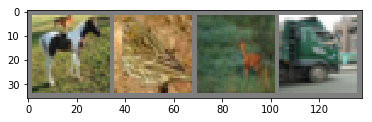

In [16]:
# In preparation for building our Convolutional Neural Network (CNN), we're going to stop using random, arbitrary vectors.
# Instead, we're going to use an actual standardized dataset: CIFAR-10
# We also have built in modules to help us load/wrangle the dataset, so we're going to use those too! (since we're spoiled)

transform = transforms.Compose( # we're going to use this to transform our data to make each sample more uniform
   [
    transforms.ToTensor(), # converts each sample from a (0-255, 0-255, 0-255) PIL Image format to a (0-1, 0-1, 0-1) FloatTensor format
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # for each of the 3 channels of the image, subtract mean 0.5 and divide by stdev 0.5
   ]) # the normalization makes each SGD iteration more stable and overall makes convergence easier

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) # this is all we need to get/wrangle the dataset!
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # each image can have 1 of 10 labels

# helper function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
# Now that we've got a lot of boilerplate code out of the way, here's how it fits in to what we did above:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 25) # now our first layer accepts inputs the size of the image's total information
        self.fc2 = nn.Linear(25, 10) # we also have 25 hidden layers
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3) # this just reshapes our tensor of image data so that we have <batch size>
        x = self.fc1(x)             # in one dimension, and then the image data in the other
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

net = Net()

NUMBER_OF_EPOCHS = 3
LEARNING_RATE = 1e-1
loss_function = nn.CrossEntropyLoss() # Changing our loss / cost function to work with our labels
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

for epoch in range(NUMBER_OF_EPOCHS):
    train_loader_iter = iter(trainloader)
    for batch_idx, (inputs, labels) in enumerate(train_loader_iter):
        net.zero_grad()
        inputs, labels = Variable(inputs.float()), Variable(labels)
        output = net(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
    print("Iteration: " + str(epoch + 1))

Iteration: 1
Iteration: 2
Iteration: 3


Predicted:    cat   car  ship plane
GroundTruth:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 39 %


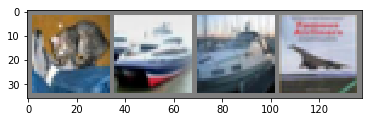

In [18]:
# Awesome! Now it's trained. Time to test it:

dataiter = iter(testloader)
images, labels = dataiter.next() # just grabbing a sample from our test data set

imshow(torchvision.utils.make_grid(images)) # display the images we're going to predict

outputs = net(Variable(images)) # get our output from our neural network
_, predicted = torch.max(outputs.data, 1) # get our predictions from the output

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# print images
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# and let's look at the overall accuracy:

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Hmm, maybe we can do better. Let's add convolutional layers.

<a id='eleven'></a>

# 11)  Adding A Convolutional Layer 

#### [Home](#outline)  |   [Back](#ten)  |   [Next](#twelve)

Links:
- https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md - Convolution animation
- http://setosa.io/ev/image-kernels/ - Image kernels explained visually (really helpful)
- http://colah.github.io/posts/2014-07-Understanding-Convolutions/ - good blog post on convolutions by Chris Olah
- http://cs231n.github.io - CS231n at stanford on CNNs, really good content

In [19]:
# here's all the boilerplate again:
transform = transforms.Compose(
   [
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
   ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # convolve each of our 3-channel images with 6 different 5x5 kernels, giving us 6 feature maps
        self.fc1 = nn.Linear(4704, 120) # but that results in a 4x6x28x28 = 18816 dimensional output, 18816/4 = 4704 inputs per image.
        self.fc2 = nn.Linear(120, 10) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.sigmoid(x)
        x = x.view(-1, 4704) # since our output from conv1 is 4x6x28x28, we need to flatten it into a 4x4704 (samples x features) tensor to feed it into a linear layer
        x = self.fc1(x)             
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

net = Net()

NUMBER_OF_EPOCHS = 3
LEARNING_RATE = 1e-1
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

for epoch in range(NUMBER_OF_EPOCHS):
    train_loader_iter = iter(trainloader)
    for batch_idx, (inputs, labels) in enumerate(train_loader_iter):
        net.zero_grad()
        inputs, labels = Variable(inputs.float()), Variable(labels)
        output = net(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
    print("Iteration: " + str(epoch + 1))

Iteration: 1
Iteration: 2
Iteration: 3


Predicted:    cat truck  ship  ship
GroundTruth:    cat  ship  ship plane


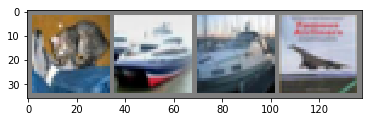

In [21]:
# Holy guacamole, that takes a LOT longer. Those convolutions are expensive.
# In the next section we'll make that a little quicker.
# For now, let's see how much our predictions improved.

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Okay... pretty good improvement. Again, before we prematurely optimize, let's add some pooling layers to make it quicker.
# THEN we'll go ham on the optimizations.

Accuracy of the network on the 10000 test images: 45 %


<a id='twelve'></a>

# 12)  Adding A Pooling Layer 

Links:
- https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks - Quora; what is max pooling?
- http://pytorch.org/docs/master/_modules/torch/nn/modules/pooling.html - pytorch documentation on pooling

#### [Home](#outline)  |   [Back](#eleven)  |   [Next](#thirteen)

In [23]:
# and again, boilerplate:
transform = transforms.Compose(
   [
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
   ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # in any 2x2 square on each of our feature maps, take the most important (highest) one
        self.fc1 = nn.Linear(1176, 120) # since we've pooled our outputs from the convolution, our input is reduced: 4704 -> 1176
        self.fc2 = nn.Linear(120, 10) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.sigmoid(x) # returns x of size: torch.Size([4, 6, 28, 28])
        x = self.pool(x) # returns x of size: torch.Size([4, 6, 14, 14]) (so we have to adjust our linear input again)
        x = x.view(-1, 1176) # now our input to the linear layer is going to be 4 by 6 * 14 * 14 = 1176
        x = self.fc1(x)             
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

net = Net()

NUMBER_OF_EPOCHS = 3
LEARNING_RATE = 1e-1
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

for epoch in range(NUMBER_OF_EPOCHS):
    train_loader_iter = iter(trainloader)
    for batch_idx, (inputs, labels) in enumerate(train_loader_iter):
        net.zero_grad()
        inputs, labels = Variable(inputs.float()), Variable(labels)
        output = net(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
    print("Iteration: " + str(epoch + 1))

Iteration: 1
Iteration: 2
Iteration: 3


Predicted:    cat   car  ship  ship
GroundTruth:    cat  ship  ship plane


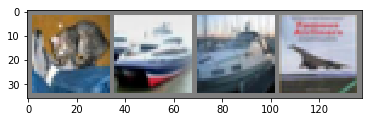

In [25]:
# Pretty significant speedup! Let's see how it affects accuracy:

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [26]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Not by much! Awesome!
# Now, let's add a few more layers, change our nonlinearities around, and do some other house keeping:

Accuracy of the network on the 10000 test images: 45 %


 <a id='thirteen'></a>

# 13) Do Some Final Optimizations (i.e. making our first sigmoid a "ReLU",  and adding more layers)

Links:
- https://github.com/Kulbear/deep-learning-nano-foundation/wiki/ReLU-and-Softmax-Activation-Functions - different activation functions
- https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks - advantages of ReLU over sigmoid

#### [Home](#outline)  |   [Back](#twelve)  |   [Next](#fourteen)

In [27]:
transform = transforms.Compose(
   [
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
   ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5) # Let's add more feature maps - that might help
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5) # And another conv layer with even more feature maps
        self.fc1 = nn.Linear(20 * 5 * 5, 120) # and finally, adjusting our first linear layer's input to our previous output
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) # we're changing our nonlinearity / activation function from sigmoid to ReLU for a slight speedup
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x) # after this pooling layer, we're down to a torch.Size([4, 20, 5, 5]) tensor.
        x = x.view(-1, 20 * 5 * 5) # so let's adjust our tensor again.
        x = self.fc1(x)             
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return x

# net = Net()
net = Net().cuda() # Let's make our NN run on the GPU (I didn't splurge on this GTX 1080 for nothing...)

NUMBER_OF_EPOCHS = 25 # Let's also increase our training cycles
LEARNING_RATE = 1e-2 # And decrease our learning rate a little bit to compensate
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

for epoch in range(NUMBER_OF_EPOCHS):
    train_loader_iter = iter(trainloader)
    for batch_idx, (inputs, labels) in enumerate(train_loader_iter):
        net.zero_grad()
        inputs, labels = Variable(inputs.float().cuda()), Variable(labels.cuda()) # Let's also make these tensors GPU compatible
        output = net(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
    if epoch % 5 is 0:
        print("Iteration: " + str(epoch + 1))

Iteration: 1
Iteration: 6
Iteration: 11
Iteration: 16
Iteration: 21


Predicted:    cat  ship plane plane
GroundTruth:    cat  ship  ship plane


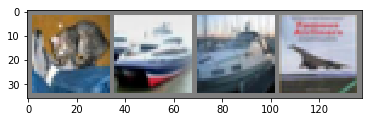

In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
outputs = net(Variable(images.cuda()))
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    inputs = Variable(images.cuda())
    labels = labels.cuda()
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Awesome! A lot better!

Accuracy of the network on the 10000 test images: 61 %


 <a id='fourteen'></a>

# 14)  Bask... in the glory that is our newly created Convolutional Neural Network (CNN)!

Links:
- http://www.yaronhadad.com/deep-learning-most-amazing-applications/ - stuff you can do now
- https://machinelearningmastery.com/inspirational-applications-deep-learning/ - more stuff you can do

#### [Home](#outline)  |   [Back](#thirteen)

Iteration: 1
Iteration: 6
Iteration: 11
Iteration: 16
Iteration: 21
Predicted:  truck   car plane plane
GroundTruth:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 62 %


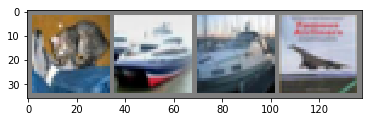

In [31]:
# Awesome - we have a full blown convolutional neural network!
# Let's condense some stuff and put it all together without comments:

transform = transforms.Compose(
   [
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
   ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5)           
        x = F.relu(self.fc1(x) )
        x = F.relu(self.fc2(x))
        return x

net = Net().cuda()

NUMBER_OF_EPOCHS = 25
LEARNING_RATE = 1e-2
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

for epoch in range(NUMBER_OF_EPOCHS):
    train_loader_iter = iter(trainloader)
    for batch_idx, (inputs, labels) in enumerate(train_loader_iter):
        net.zero_grad()
        inputs, labels = Variable(inputs.float().cuda()), Variable(labels.cuda())
        output = net(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
    if epoch % 5 is 0:
        print("Iteration: " + str(epoch + 1))

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
outputs = net(Variable(images.cuda()))
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

correct = 0
total = 0
for data in testloader:
    images, labels = data
    labels = labels.cuda()
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))